Este documento es un ejemplo de uso de Apache Spark. Spark se puede utilizar a día de hoy con 3 lenguajes de programación: Java, Scala y Python (R está en progreso). Estos ejemplos utilizan Python con Spark (que se llama PySpark).

![Foto del logo de Spark](http://docs.sigmoidanalytics.com/images/c/ce/Sparkimage.png "Optional title")

Una de las ventajas de Spark es que en un mismo programa/script/documento podemos mezclar código nativo en un lenguaje de programación (en este caso Python) con comandos y análisis hechos en Spark. Vamos a comenzar utilizando el Python estándar (sin Spark) para descargarnos unos cuantos tweets (Twitter nos pone el límite en 200). 

Para hacerlo, importamos la biblioteca de la API de Python para Twitter (hay varias bibliotecas para hacer esto; yo he elegido [python-twitter](https://github.com/bear/python-twitter) que es la que mejor conozco). Importamos la biblioteca y metemos las credenciales de mi cuenta de twitter:

In [1]:
import twitter

api = twitter.Api(consumer_key='cR9gdhHZ0kgtmqVY2qbshD1Ou',
                      consumer_secret='dVKQ2T7ARzvqu0E9nMSvhAcsMoacBB1tyUnYn2MyYkE49g9pd9',
                      access_token_key='2510805482-usRSfdVL8Ida2MZ9x8A6SHimp0xXid7epWcmqQX',
                      access_token_secret='hngBuDRK0WOlsX0RcVA6u4sQO6cLVOe6eNaSt28GLSCUh')

Ahora nos descargamos los últimos 200 tweets de [@MSMK_](https://twitter.com/msmk_) y los metemos en una variable llamada `statuses` (es posible que salga un Warning; es porque no estamos utilizando SSL para descargarnos los tweets. Pero no importa):

In [2]:
statuses = api.GetUserTimeline(screen_name="MSMK_",count=200)

Ahora la variable statuses es una lista con 200 tweets. Podemos ver por ejemplo el primero (vemos que el tweet está en formato JSON):

In [3]:
statuses[1].AsDict()

{'created_at': u'Wed Aug 05 15:16:10 +0000 2015',
 'favorited': False,
 'hashtags': [u'MarketingDigital'],
 'id': 628947613270831104L,
 'lang': u'es',
 'retweeted': False,
 'source': u'<a href="http://www.hootsuite.com" rel="nofollow">Hootsuite</a>',
 'text': u'Forma parte de un proyecto formativo \xfanico que a\xfana las herramientas con la visi\xf3n estrat\xe9gica http://t.co/vZLA5J3X5x #MarketingDigital',
 'truncated': False,
 'urls': {u'http://t.co/vZLA5J3X5x': u'http://ow.ly/PZ3ZT'},
 'user': {'created_at': u'Sun Apr 08 11:33:18 +0000 2012',
  'description': u'Twitter Oficial de Madrid School of Marketing. Alta especializaci\xf3n en marketing para BigData Business Intelligence Retail Marketing Digital Ecommerce Branding',
  'favourites_count': 2208,
  'followers_count': 2522,
  'friends_count': 2775,
  'geo_enabled': True,
  'id': 548355494,
  'lang': u'es',
  'listed_count': 208,
  'location': u'Madrid, Spain ',
  'name': u'@MSMK_',
  'profile_background_color': u'006FB7',
  'pro

Ahora vamos a coger los 200 tweets y vamos a guardarlos en un archivo JSON al que vamos a llamar `tweets.json`:

In [4]:
import json
endict = []
for i in statuses:
    j = i.AsDict()
    endict.append(j)
    
with open('tweets.json',"w") as archivo:
    for i in endict:
        r = json.dumps(i)
        archivo.write(r)
        archivo.write("\n")

Hasta ahora lo que hemos hecho ha sido: conectarnos a Twitter, descargarnos 200 tweets y guardarlos en un archivo JSON; y para ello hemos utilizado únicamente Python de forma normal. Es el momento de empezar a usar Spark.

Spark, a diferencia de Hadoop MapReduce, nos permite hacer un análisis más interactivo a través de la línea de comandos (o de un Jupyter Notebook en este caso). No obstante, Spark puede correr también como un programa normal estilo MapReduce, ejecutándolo desde la terminal (de forma puntual o periódicamente) y esperando a que nos devuelva el resultado.

Otra ventaja de Spark es que nos permite utilizar directamente desde Spark algunos de los otros animalitos del zoo, como son Hive y Pig (y otros muchos). Vamos a utilizar Hive.

Recordemos que Hive nos permite ejecutar queries/consultas SQL sobre archivos que están en HDFS. Así que vamos a utilizar Hive desde Spark para analizar nuestro archivo `tweets.json` utilizando consultas SQL. 

**Nota:** todo lo que se hace con archivos desde Spark puede estar **o no** en HDFS; con esto quiero decir que Spark puede leer directamente desde el sistema de archivos normal de nuestro sistema operativo. No obstante, lo ideal es que los archivos que analicemos en Spark estén en HDFS (en la mayoría de los casos).

Para utilizar Hive desde Spark, comenzamos por importar algunas bibliotecas de Hive que vienen con nuestra instalación de Spark:

In [5]:
from pyspark.sql import HiveContext, Row, SQLContext
#hv = HiveContext(sc)

sql_context = SQLContext(sc)

Hemos creado una variable especial `hv` que es lo que se llama un HiveContext (el conector entre Hive y Spark). Ahora le decimos a Hive que el archivo que queremos utilizar es `tweets.json`; y puesto que en Hive tenemos que registrar las tablas antes de utilizarlas, la registramos con el nombre de `tweets_msmk`:

In [6]:
archivo_de_entrada = sql_context.read.json('tweets.json')
archivo_de_entrada.registerTempTable("tweets_msmk")

Una vez registrada la tabla, ya podemos utilizar consultas SQL usando Hive.

Vamos a coger los 10 tweets más retuiteados:

In [7]:
topTweets = sql_context.sql("""SELECT text, 
                      retweet_count FROM tweets_msmk 
                      WHERE retweet_count IS NOT NULL
                      ORDER BY retweet_count DESC
                      LIMIT 10
                      """)

La variable topTweets, que contiene los 10 tweets más retuiteados, es un objeto especial de Spark que solía llamarse SchemaRDD, pero que los desarrolladores han rebautizado recientemente como Spark DataFrame, por sus similitudes con los data frames de R y Python. Pero es un objeto de Spark.

*Nota*: los objetos de Spark se llaman RDD (Resilient Distributed Datasets). Un RDD no es más que un dataset distribuido en memoria; de forma que si tenemos 10 ordenadores corriendo Spark y un RDD tiene 100 datos, cada uno de los ordenadores tendrá el 10 por ciento del dataset en su memoria RAM (más redundancias para tolerar posibles fallos de hardware).

El Spark DataFrame es uno de los tipos de RDD que vienen con Spark:

In [8]:
topTweets

DataFrame[text: string, retweet_count: bigint]

Ahora podemos "traernos" el DataFrame topTweets desde Spark a Python haciendo `collect()`, lo cual nos permite ver su contenido:

**Nota:** en este ejemplo no tenemos problema en "traernos" el contenido de una consulta Hive a Python, puesto que solo son 10 tweets. Si la consulta, en vez de 10 tweets nos devolviera 10 millones, nuestro ordenador moriría.

In [9]:
topTweets.collect()

[Row(text=u'RT @yodominguez: Ellas enfermas y muertas. Ellos superh\xe9roes y jefes. Los ni\xf1os dejan en evidencia al mundo de la #moda #ni\xf1osvsmoda http:/\u2026', retweet_count=22),
 Row(text=u'RT @AliciaDavara: #Comercio. Donde quiera que el cliente est\xe9. Esencia #MadridRetailCongress  febrero 2016 2\xaa edici\xf3n http://t.co/sndBt5tO1\u2026', retweet_count=8),
 Row(text=u'RT @Ecommerce_es: El #RealMadrid lanza su tienda online en el gigante chino #Tmall.com http://t.co/uYnEJkWyXs @realmadrid', retweet_count=4),
 Row(text=u'As\xed fue la II Feria de #Empleo de #BigData donde presentamos el observatorio de empleo con @ticjob http://t.co/uerTL6yjja', retweet_count=3),
 Row(text=u'RT @FutureBrand_Es: #FelizMartes de #branding: No te pierdas la expo de #AlbertoCoraz\xf3n http://t.co/PN9JsDoW0T http://t.co/YG8feWvkzh v\xeda @\u2026', retweet_count=3),
 Row(text=u'RT @Interactiv_a: Inversi\xf3n en #marketing y #publicidad crece y se consolida por 1\xaa vez con datos positivos para

Ahora vamos a hacer otra consulta Hive. En ella nos vamos a quedar con el texto de cada tweet y sus retweets, para los 200 tweets que tenemos:

In [10]:
textoDeTweets = sql_context.sql("""SELECT text, retweet_count FROM tweets_msmk""")

Vale; ya tenemos solo el texto y retweets de los 200 tweets en una variable llamada `textoDeTweets` (que es un Spark DataFrame/RDD). Vamos a hacer el famoso wordcount en Spark.

Conclusiones hasta el momento: hemos utilizado Python y la API de Twitter para descargarnos 200 tweets y guardarlos en un archivo JSON. Luego, hemos utilizado Hive para lanzar consultas SQL sobre ese JSON, y los resultados de esas consultas los guardamos en DataFrames (RDDs) de Spark. Ahora vamos a operar sobre uno de esos RDDs en Spark, haciendo un wordcount.

Empezamos haciendo un map en Spark para quedarnos solo con el texto y "pasar" de los retweets:

In [11]:
cadatexto = textoDeTweets.map(lambda x: x.text)

Veamos qué ha hecho Spark utilizando de nuevo `collect`, y mostrando solo las primeras 10 líneas (para no saturar el documento con 200 líneas de texto):

In [12]:
cadatexto.collect()[:10]

[u'5 tendencias sobre el contenido de marca http://t.co/PQphlDnVsz por @javierregueira #Branding',
 u'Forma parte de un proyecto formativo \xfanico que a\xfana las herramientas con la visi\xf3n estrat\xe9gica http://t.co/vZLA5J3X5x #MarketingDigital',
 u'\xbfQu\xe9 compra el consumidor espa\xf1ol online? http://t.co/Ad9zBpqTSS v\xeda @PuroMarketing',
 u'Mobile Addiction; \xbftendencia, amenaza u oportunidad? http://t.co/urRAmiz2j2 v\xeda @daretail',
 u'Descubre qui\xe9nes son los aut\xe9nticos superh\xe9roes del #BigData y sus superpoderes. http://t.co/0pfO4LJRfb',
 u'Antes de ser un logo, una #marca es un contenedor de significado http://t.co/U504cnTAwJ v\xeda @ReasonW CC @brandsmith_esp @Emeritomartinez',
 u'La Ruta de Scouting fue una de las actividades extraaced\xe9micas de los alumnos de Moda y Lujo http://t.co/r7bMJA5RNW http://t.co/DLLKh8PKIZ',
 u'Las 10 herramientas imprescindibles para el #DataScientist http://t.co/CeQHHTrFxW #BigData',
 u'Elabora el plan de #marketing y lider

Podemos ver que ya tenemos algo muy similar a lo que tendríamos en un archivo en HDFS (un montón de líneas, cada una con un texto), con la diferencia de que, puesto que estamos en Spark, dichas líneas están distribuidas en memoria y no en disco duro.

Ahora, hagamos otro map. Esta vez, uno que nos separe cada palabra:

In [13]:
separado = cadatexto.flatMap(lambda x: x.split())

Comprobamos (mostrando las primeras 20 palabras):

In [14]:
separado.collect()[:20]

[u'5',
 u'tendencias',
 u'sobre',
 u'el',
 u'contenido',
 u'de',
 u'marca',
 u'http://t.co/PQphlDnVsz',
 u'por',
 u'@javierregueira',
 u'#Branding',
 u'Forma',
 u'parte',
 u'de',
 u'un',
 u'proyecto',
 u'formativo',
 u'\xfanico',
 u'que',
 u'a\xfana']

Y ahora vamos a tirar más de "filosofía MapReduce". Podéis ver que en el resultado anterior hemos separado por palabras, pero que no existe ningún tipo de clave-valor (solo clave; cada palabra). Para hacer un wordcount suele ser útil tener los datos en pares clave-valor, así que vamos a darle valor a cada clave con otro map (un 1 a cada clave):

In [15]:
clave_valor = separado.map(lambda x: (x, 1))

clave_valor.collect()[:20]

[(u'5', 1),
 (u'tendencias', 1),
 (u'sobre', 1),
 (u'el', 1),
 (u'contenido', 1),
 (u'de', 1),
 (u'marca', 1),
 (u'http://t.co/PQphlDnVsz', 1),
 (u'por', 1),
 (u'@javierregueira', 1),
 (u'#Branding', 1),
 (u'Forma', 1),
 (u'parte', 1),
 (u'de', 1),
 (u'un', 1),
 (u'proyecto', 1),
 (u'formativo', 1),
 (u'\xfanico', 1),
 (u'que', 1),
 (u'a\xfana', 1)]

Eso está mejor. Ahora ya podemos hacer un reduce. En Spark, hay varios tipos de reduce distintos. En este ejemplo, vamos a utilizar el equivalente al de Hadoop MapReduce, que en Spark resulta llamarse `reduceByKey`:

In [16]:
reducido = clave_valor.reduceByKey(lambda x,y: x + y)

reducido.collect()[:20]

[(u'futuro:', 1),
 (u'sushi,', 1),
 (u'Seg\xfan', 1),
 (u'@ReasonW', 9),
 (u'\xbfy', 1),
 (u'8,4%', 1),
 (u'observatorio', 1),
 (u'pide', 1),
 (u'aniversario.', 1),
 (u'ciudad', 1),
 (u'gana', 1),
 (u'@josecantero', 2),
 (u'espa\xf1oles', 2),
 (u'http://t.co/uPeVIETTLY', 1),
 (u'http://t.co/pCwGVEWdWY', 1),
 (u'prometedor', 1),
 (u'habla', 1),
 (u'seg\xfan', 4),
 (u'hablaremos', 1),
 (u'http://t.co/EYfDIRTMXo', 1)]

¡Y ya está terminado nuestro wordcount sobre los 200 tweets! Vamos a ordenarlos de mayor a menor:

In [17]:
reducido_y_ordenado = reducido.sortBy(lambda x: x[1], ascending=False)

reducido_y_ordenado.collect()[:20]

[(u'de', 163),
 (u'en', 95),
 (u'y', 67),
 (u'v\xeda', 65),
 (u'el', 59),
 (u'la', 51),
 (u'con', 45),
 (u'a', 38),
 (u'del', 34),
 (u'RT', 33),
 (u'las', 31),
 (u'los', 31),
 (u'@jcortecero', 30),
 (u'que', 27),
 (u'para', 27),
 (u'un', 26),
 (u'El', 21),
 (u'por', 21),
 (u'm\xe1s', 18),
 (u'#Branding', 14)]

Para demostrar de nuevo la interactividad entre Python y Spark, vamos a traernos esas 20 top words a una variable Python a la que vamos a llamar `resultados`:

In [18]:
resultados = reducido_y_ordenado.collect()[:20]

Resulta que Python, al igual que R, tiene muchas bibliotecas para hacer análisis de datos (ojo: no de forma paralela y distribuida como Hadoop MapReduce y Spark), así como para visualizar los datos. Vamos a utilizar [numpy](http://www.numpy.org/), [pandas](http://pandas.pydata.org/) y [matplotlib](http://matplotlib.org/) para hacer un barplot de los resultados de nuestro wordcount:

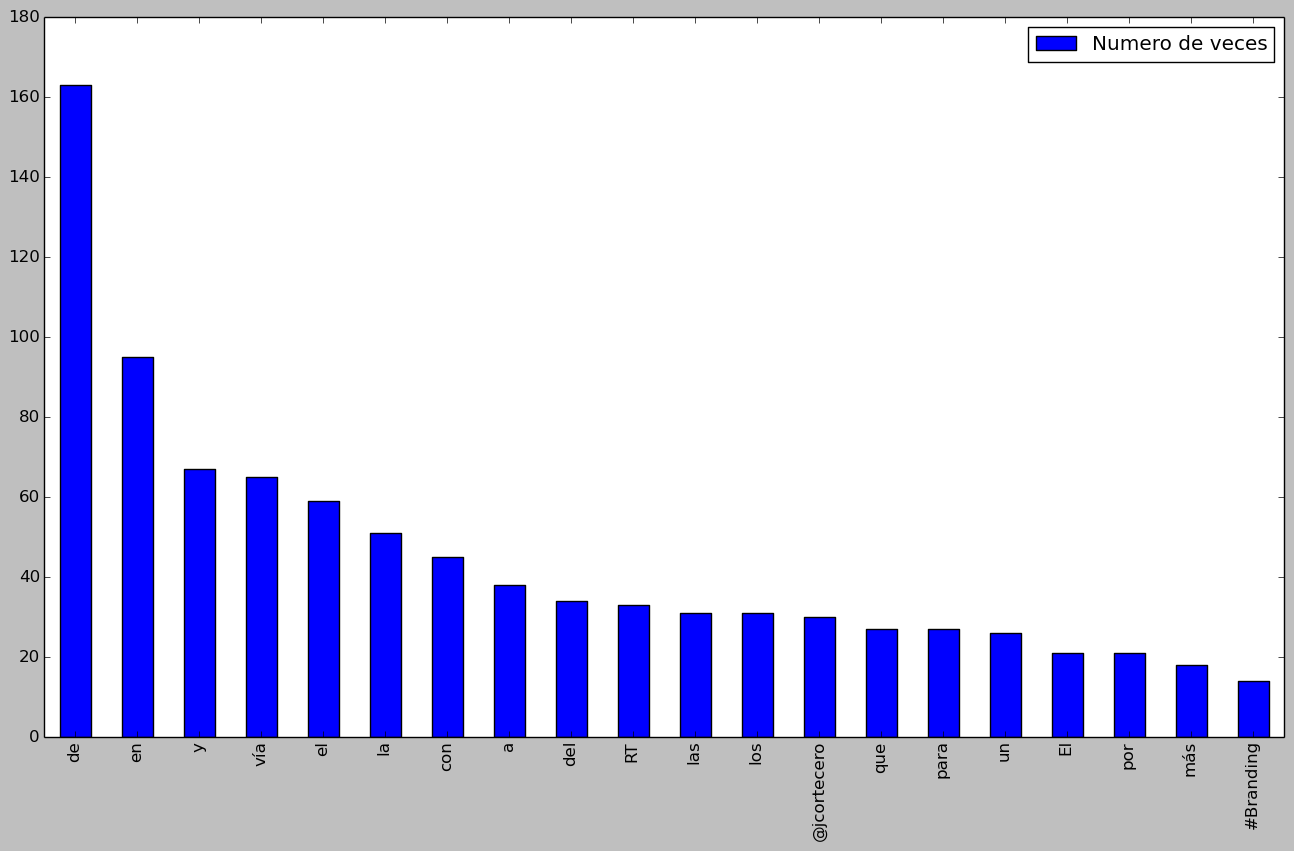

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas

# matplotlib viene con una biblioteca para que el estilo
# de los gráficos sea como el de ggplot de R:
#plt.style.use("ggplot")

lista_de_keys = []
lista_de_values = []

for cadatupla in resultados:
    lista_de_keys.append(cadatupla[0])
    lista_de_values.append(cadatupla[1])
    
tablita = pandas.DataFrame({"Numero de veces": lista_de_values},
                          index = lista_de_keys)

tablita.plot(kind="bar", figsize=(16,9))

Spark es capaz de hacer más operaciones aparte de map y reduce. No obstante, en la práctica los maps y reduces suelen ser lo más eficaz en la mayoría de los casos.

Excepto cuando quieres meterte más en el tema de data mining y machine learning...

##Data Mining con Spark MLlib

Spark incluye una biblioteca de datamining y machine learning que se llama MLlib.

MLlib es un conjunto de funciones que permiten realizar modelos en Spark de forma distribuida.

Vamos a hacer como ejemplo un modelo que intente predecir el número de retweets que tendría un tweet en el caso de ser publicado. Para ello, volvemos a utilizar la variable `textoDeTweets` (nuestra segunda consulta de Hive). Pero antes de poder hacer el modelo, tenemos que preocuparnos de limpiar los datos.

Resulta que el el JSON de un tweet de Twitter que no ha tenido ningún retweet, ni siquiera aparece el campo `retweet_count`. Hive lo sabe, así que en los tweets que no han sido retuiteados el tweet_count es igual a `None`. Pero `None` es una palabra en vez de un número lo cual complicaría la realización del modelo; preferiríamos que en vez de `None` fuera un 0...

In [20]:
textoDeTweets.collect()[:10]

[Row(text=u'5 tendencias sobre el contenido de marca http://t.co/PQphlDnVsz por @javierregueira #Branding', retweet_count=1),
 Row(text=u'Forma parte de un proyecto formativo \xfanico que a\xfana las herramientas con la visi\xf3n estrat\xe9gica http://t.co/vZLA5J3X5x #MarketingDigital', retweet_count=None),
 Row(text=u'\xbfQu\xe9 compra el consumidor espa\xf1ol online? http://t.co/Ad9zBpqTSS v\xeda @PuroMarketing', retweet_count=None),
 Row(text=u'Mobile Addiction; \xbftendencia, amenaza u oportunidad? http://t.co/urRAmiz2j2 v\xeda @daretail', retweet_count=None),
 Row(text=u'Descubre qui\xe9nes son los aut\xe9nticos superh\xe9roes del #BigData y sus superpoderes. http://t.co/0pfO4LJRfb', retweet_count=None),
 Row(text=u'Antes de ser un logo, una #marca es un contenedor de significado http://t.co/U504cnTAwJ v\xeda @ReasonW CC @brandsmith_esp @Emeritomartinez', retweet_count=None),
 Row(text=u'La Ruta de Scouting fue una de las actividades extraaced\xe9micas de los alumnos de Moda y Luj

¿Lo ves? Vamos a hacer un map que coja las líneas que tienen `None` y los convierta en `0`:

In [21]:
textoDeTweets_con_ceros = textoDeTweets.map(lambda x: (x.text, 0) if 
                                            x.retweet_count==None else 
                                            (x.text, x.retweet_count))

In [22]:
textoDeTweets_con_ceros.collect()[:10]

[(u'5 tendencias sobre el contenido de marca http://t.co/PQphlDnVsz por @javierregueira #Branding',
  1),
 (u'Forma parte de un proyecto formativo \xfanico que a\xfana las herramientas con la visi\xf3n estrat\xe9gica http://t.co/vZLA5J3X5x #MarketingDigital',
  0),
 (u'\xbfQu\xe9 compra el consumidor espa\xf1ol online? http://t.co/Ad9zBpqTSS v\xeda @PuroMarketing',
  0),
 (u'Mobile Addiction; \xbftendencia, amenaza u oportunidad? http://t.co/urRAmiz2j2 v\xeda @daretail',
  0),
 (u'Descubre qui\xe9nes son los aut\xe9nticos superh\xe9roes del #BigData y sus superpoderes. http://t.co/0pfO4LJRfb',
  0),
 (u'Antes de ser un logo, una #marca es un contenedor de significado http://t.co/U504cnTAwJ v\xeda @ReasonW CC @brandsmith_esp @Emeritomartinez',
  0),
 (u'La Ruta de Scouting fue una de las actividades extraaced\xe9micas de los alumnos de Moda y Lujo http://t.co/r7bMJA5RNW http://t.co/DLLKh8PKIZ',
  0),
 (u'Las 10 herramientas imprescindibles para el #DataScientist http://t.co/CeQHHTrFxW #

Ahora ya podemos comenzar a minar. Por los caracteres alfanuméricos raros como palabras con tilde, que arriba salen feos, no hay que preocuparse. A pesar de que salen escritos de forma fea, Spark los entiende perfectamente. Para comprobarlo, cojamos el tercer tweet e imprimámoslo en bonito:

In [23]:
print(textoDeTweets_con_ceros.collect()[2][0])

¿Qué compra el consumidor español online? http://t.co/Ad9zBpqTSS vía @PuroMarketing


Reconoce bien tildes y signos de interrogación. No hay problema entonces. Podemos continuar.

Vamos a realizar un conjunto de regresiones lineales para intentar predecir el número de retweets. Para ello, tenemos que hacer una serie de trasformaciones del dataset (pares de tweets y retweets) utilizando para ello la API de Spark SQL. A pesar de que se llama Spark SQL, no tiene por qué estar relacionado con SQL o bases de datos relacionales. Sirve más que nada para dar una estructura a nuestro RDD (dataset). Por ejemplo, tenemos que convertir cada `retweet_count` de número entero a número decimal (lo que sería un float de Python o un numeric de R).

Una vez hecho, ya tenemos nuestro dataset completamente preparado, en un RDD al que vamos a llamar `dataset_limpio`:

In [24]:
RDD_limpio = textoDeTweets_con_ceros.map(lambda x: (x[0], float(x[1])))

from pyspark.sql import SQLContext, Row
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

tableContext = SQLContext(sc)


esquema = StructType([
        StructField("texto", StringType(), True),
        StructField("retweets", DoubleType(), True)])

dataset_limpio = tableContext.createDataFrame(RDD_limpio, schema=esquema)

Lo que vamos a hacer no deja de ser un ejercicio de text mining. En el text mining, tenemos que comenzar por convertir el texto a números que nuestro algoritmo pueda entender. Para ello, separamos cada tweet en las palabras que lo forman, normalizadas (convirtiendo todo a minúsculas y eliminando espacios) utilizando para eso el `Tokenizer` de Spark MLlib. Esto nos devuelve un array de palabras por cada tweet. 

Para convertir palabras a vectores numéricos existen muchas técnicas. Una de las más extendidas y efectivas es el algoritmo TF (Term-Frequency). TF computa un vector de frecuencia de términos de un tamaño dado. Para "mapear" términos a índices del vector, la implementación TF de Spark MLlib (`HashingTF`) utiliza una técnica llamada *hashing trick*. Spark convierte cada palabra a un hash (una purrela de letras y números) utilizando como modulo (matemático) un vector de un tamaño $T$, y mapea entonces cada palabra a un número entre $0$ y $T-1$. Esta técnica nos devuelve siempre un vector $T$-dimensional.

Dicho más fácil: cada palabra se transforma en un vector con muchos números. A este vector se le suele llamar en data mining *feature vector*. Nosotros le llamamos "features" en este ejemplo:

In [25]:
from pyspark.ml.feature import HashingTF, Tokenizer

tokenizer = Tokenizer().setInputCol("texto").setOutputCol("palabras")

tf = HashingTF().setInputCol("palabras").setOutputCol("features")

O sea: hemos cogido cada uno de los 200 tweets, los hemos separadao por palabras y hemos aplicado `HashingTF`.

Puesto que ya tenemos el texto transformado a números, ya podemos aplicar modelos de data mining. Como dije anteriormente, vamos a aplicar regresión lineal (que debería sonaros de SAS):

In [26]:
from pyspark.ml.regression import LinearRegression

regresion = LinearRegression(featuresCol="features",labelCol="retweets")

Desde la versión 1.2 de Spark se ha estado trabajando en un modelo de pipelining, con el objetivo de hacer más sencillo el proceso de minado de datos para los programadores. 

Si estás acostumbrado a SAS (ya sea el Enterprise Miner o e Text Miner), sabrás que en SAS vas cogiendo nodos con modelos y transformaciones, y los vas uniendo con flechas; de forma que los datos que salen de un nodo son los datos de entrada del siguiente. 

Podemos hacer lo mismo con Spark, utilizando para ello el Pipeline de Spark MLlib. Si os fijáis en el código anterior, podemos ver:

1. El `Tokenizer` recibe una columna llamada "texto", y devuelve una columna llamada "palabras" (un array de las palabras de cada tweet).
2. Nuestro `HashingTF` recibe la columna "palabras" del paso anterior, y devuelve otra llamada "features".
3. Nuestra regresión recibe "features", y una `labelCol`, que no es más que el número de retweets en sí.

Lo tenemos muy sencillo para construir el diagrama. Utilizamos `Pipeline` de MLlib, y le ponemos el orden que queremos que siga el proceso (primero el Tokenizer, luego el TF, y luego la regresión):

In [27]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages([tokenizer, tf, regresion])

Ya tenemos entonces el camino a seguir. Pero todavía no hemos hablado de validación, ni de comparación de modelos. En este ejemplo vamos a realizar muchos modelos distintos, aunque de momento no lo parezca. 

Por ejemplo: dentro de la técnica de `HashingTF`, deberíamos definir distintas formas de hacerla, y ver cuál es la que mejor funciona. Ya comentamos que el resultado de TF depende del tamaño de vector $T$ que elijamos. En la bibliografía sobre el tema se suele recomendar un $T$ de entre $2^{10}$ y $2^{30}$. Así que nosotros vamos a definir tamaños de $T$ entre 10.000 y 90.000, de 10.000 en 10.000.

Por otro lado, para la regresión podemos definir el número de iteraciones que queramos que haga el algoritmo. Ponemos un mínimo de 30, máximo de 300, aumentando de 50 en 50.

De modo que ya tenemos una gran cantidad de modelos, puesto que Spark hace todas las combinaciones posibles, buscando la que mejor funciona:

+ TF de 10.000 + regresión de 30 iteraciones
+ TF de 10.000 + regresión de 80 iteraciones
+ TF de 20.000 + regresión de 30 iteraciones
+ TF de 20.000 + regresión de 80 iteraciones
+ TF de 10.000 + regresión de 130 iteraciones
+ TF de 20.000 + regresión de 130 iteraciones
+ TF de 30.000 + regresión de 30 iteraciones
+ TF de 30.000 + regresión de 80 iteraciones
+ TF de 30.000 + regresión de 130 iteraciones

Etcétera etcétera.

Una vez construidos todos esos modelos (48 para ser exactos), hay que validar para comprobar cuál es el que mejor funciona. Si bien en SAS se suele separar antes una parte del dataset para validación, cuando tenemos gran cantidad de datos (Big Data) suele ser mejor utilizar técnicas especiales de validación que no nos obligan a separar parte del dataset, sino que hace validaciones implícitas. Una de las más utilizadas es la validación cruzada (*Cross Validation*), que en el caso de Spark utiliza la técnica K-fold (separación dinámica de una parte K de dataset).

En el código de abajo definimos primero todas las combinaciones de modelos, y luego efectuamos la validación cruzada. Como medida de la validación utilizamos el error cuadrático medio ("mse"):

In [28]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

pool_de_modelos = ParamGridBuilder() \
    .addGrid(tf.numFeatures, range(10000,90000,10000)) \
    .addGrid(regresion.maxIter, range(30, 300, 50)) \
    .build()

evaluador_regresion = RegressionEvaluator(predictionCol="prediction", labelCol="retweets", metricName="mse")

validador = CrossValidator() \
    .setEstimator(pipeline) \
    .setEstimatorParamMaps(pool_de_modelos) \
    .setEvaluator(evaluador_regresion)

Cuando ejecutemos el código de abajo será, en realidad, cuando se computen los modelos siguiendo el diagrama definido en nuestra pipeline, generando todas las combinaciones, validando los modelos y quedándose con el mejor:

In [29]:
dataset_limpio.cache()
mejor_modelo = validador.fit(dataset_limpio)

La variable `mejor_modelo` contiene el modelo "ganador", es decir, el que mejor resultado ha dado tras construir todos los modelos y la validación. Una vez elegido el modelo ganador, vamos a aplicarlo para predecir el número de retweets que tendrían una serie de tweets que nos vamos a inventar, en el caso de que fueran publicados por @MSMK_:

In [40]:
tweets_hipoteticos = sc.parallelize([("Muchas gracias a todos los que estais dia a dia en las redes sociales #personas #FelizLunes",),
                                    ("Hadoop",),
                                    ("La historia de los JJOO a traves de sus logotipos",),
                                    ])

# Los preparamos para meterlos en el modelo:
tweets_hipoteticos = tableContext.createDataFrame(tweets_hipoteticos, schema=["texto"])

# Y los metemos:
predicciones = mejor_modelo.transform(tweets_hipoteticos)[["texto","prediction"]].collect()


# Construimos una tablita con los resultados:
predicciones_en_tablita = pandas.DataFrame(numpy.asarray(predicciones))
predicciones_en_tablita.columns = ["Tweet", "Prediccion de retweets"]
predicciones_en_tablita["Prediccion de retweets"]=numpy.trunc(
                                                    predicciones_en_tablita["Prediccion de retweets"]\
                                                    .astype("float"))
predicciones_en_tablita

,Tweet,Prediccion de retweets
0,Muchas gracias a todos los que estais dia a di...,0
1,Hadoop,0
2,La historia de los JJOO a traves de sus logotipos,0


¡Espero que te haya gustado!